In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

In [50]:
RUN = 'nogreen_full_3H_ws'

INPUT="/mnt/c/Users/scl38887/Documents/git/aldehyde/results/" + RUN + "/integrated_comp/stats.csv"
OUTPUT="/mnt/c/Users/scl38887/Documents/git/aldehyde/results/" + RUN + "/graphics/integrated_comp/"

### Data preparation

In [51]:
def prepare_data(data, zerofilter=False):
    # Prepare the data
    # Extract the Co2L which is in position 5-8
    data["opts"] = data["opts"].str[4:]

    # Rescale the cost from euro to B€
    data["cost"] = data["cost"] / 1e9

    # Round the data to 2 decimals
    data = data.round(2)

    # Filter the data to remove 0 export and 0 co2 reduction
    print(f"zerofiler is set to {zerofilter} or in boolean {bool(zerofilter)}")
    if zerofilter:
        print("Filtering data")
        #data = data[(data["h2export"] != 0) & (data["opts"] != "2.0")]
        data = data[(data["h2export"] != 0)]

    else:
        pass

    return data


In [52]:
def reshape_data(data, opts, h2export, plottype):
    # Reshape the data for all columns in to_round and save it in data dictionary
    data_reshaped = {}
    # TODO loop is not necessary since I only use one plottype
    for i in [plottype]:
        data_reshaped[i] = data[i].values.reshape(len(opts), len(h2export)).T

    return data_reshaped

### Plotting config & function

In [53]:
# Prepare the data
levels = 7 # 20 recommended for "cf", 7 for others
show_minimums = False
zerofilter = False
category = "capacity" # Select ["supply", "capacity", "cf"]

data = pd.read_csv(INPUT)
data = prepare_data(data, zerofilter=zerofilter)

h2export = np.unique(data["h2export"])
opts = np.unique(
    data["opts"].fillna(100).astype(float)
)  # TODO improve the fillna value

el_base_demand = min(reshape_data(data, opts, h2export, plottype="el_base_demand")["el_base_demand"][0])

#data_reshaped = reshape_data(data, opts, h2export, plottype=plottype)


zerofiler is set to False or in boolean False


In [54]:
def plot_data(ax, data_reshaped, plottype, levels, cmap, title):
    # Turn "limit" to "reduction" (e.g. Co2L0.90 means 10% reduction)
    opts_reverse = 1 - opts
    opts_reverse[opts_reverse < 0] = 0

    # Plot a contour plot of the data having the y-axis the column "h2export", x-axis the column "sopts", and the z-axis the column "cost"
    #fig = plt.figure(figsize=(9, 6))
    contour = ax.contourf(
        opts_reverse * 100,
        h2export,
        np.flip(data_reshaped[plottype], axis=1),
        levels=levels,
        #colors=["green", "red"],
        cmap=cmap,
    )
    plt.colorbar(contour, ax=ax, orientation='vertical')#.set_label("Capacity in GW")
    ax.set_title(title)


    return contour

### Plot data

In [55]:
def create_cmap(rgb):
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, rgb[0]/256, N)
    vals[:, 1] = np.linspace(1, rgb[1]/256, N)
    vals[:, 2] = np.linspace(1, rgb[2]/256, N)
    my_cmap = ListedColormap(vals)
    return my_cmap

In [56]:
data.columns

Index(['h2export', 'opts', 'cost', 'mg_H2_inclu_Fisch_all',
       'mg_H2_exclu_Fisch_all', 'mg_H2_False_False_exportonly',
       'mg_H2_False_False_noexport', 'mg_H2_False_False_all',
       'mg_AC_exclu_H2 El_all', 'mg_AC_inclu_H2 El_all',
       'mg_AC_False_False_all', 'mg_oil_False_False_all',
       'mg_gas_False_False_all', 'lcoh_system', 'lcoh_compo', 'capex_share',
       'capex_ely', 'capex_ely_rel', 'opex_ely', 'opex_ely_rel', 'H2_GWh',
       'Battery_GWh', 'EV_Battery_GWh', 'H2export_GWh', 'ratio_H2_Battery',
       'curtailmentrate_solar', 'curtailmentrate_wind', 'el_base_demand',
       'cf_electrolysis', 'pv_capex', 'pv_p_nom_opt', 'onshore_capex',
       'onshore_p_nom_opt', 'coal_capex', 'coal_p_nom_opt', 'ccgt_capex',
       'ccgt_p_nom_opt', 'ror_capex', 'ror_p_nom_opt', 'oil_capex',
       'oil_p_nom_opt', 'ocgt_capex', 'ocgt_p_nom_opt', 'pv_supply', 'pv_cf',
       'onshore_supply', 'onshore_cf', 'coal_supply', 'coal_cf', 'ccgt_supply',
       'ccgt_cf', 'ror_sup

In [57]:
params = {"Onshore Wind": {"capacity": "onshore_p_nom_opt", 
                           "supply": "onshore_supply",
                           "cf": "onshore_cf",
                           "rgb": [18, 143, 207],     
                           "title": "Onshore Wind"},
                "Solar PV": {"capacity": "pv_p_nom_opt", 
                            "supply": "pv_supply",
                                "cf": "pv_cf",
                            "rgb": [228, 203, 58], 
                            "title": "Solar PV"},
               "Coal": {"capacity": "coal_p_nom_opt",
                        "supply": "coal_supply",
                        "cf": "coal_cf",
                        "rgb": [80, 80, 80], 
                        "title": "Coal"},
               "OCGT": {"capacity": "ocgt_p_nom_opt",
                        "supply": "ocgt_supply",
                        "cf": "ocgt_cf",
                        "rgb": [228, 147,44], 
                        "title": "OCGT"},
                "ror": {"capacity": "ror_p_nom_opt",
                        "supply": "ror_supply",
                        "cf": "ror_cf",
                        "rgb": [27, 90, 166], 
                        "title": "ROR"},
                "oil": {"capacity": "oil_p_nom_opt",
                        "supply": "oil_supply",
                        "cf": "oil_cf",
                        "rgb": [0, 0, 0], 
                        "title": "Oil"},
                "CCGT": {"capacity": "ccgt_p_nom_opt",
                        "supply": "ccgt_supply",
                        "cf": "ccgt_cf",
                        "rgb": [228, 147,44], # TODO change color
                        "title": "CCGT"},
}

cbar_label = {"supply": "Supply in TWh",
              "capacity": "Capacity in GW",
                "cf": "Capacity Factor",
              }

In [58]:
data.columns

Index(['h2export', 'opts', 'cost', 'mg_H2_inclu_Fisch_all',
       'mg_H2_exclu_Fisch_all', 'mg_H2_False_False_exportonly',
       'mg_H2_False_False_noexport', 'mg_H2_False_False_all',
       'mg_AC_exclu_H2 El_all', 'mg_AC_inclu_H2 El_all',
       'mg_AC_False_False_all', 'mg_oil_False_False_all',
       'mg_gas_False_False_all', 'lcoh_system', 'lcoh_compo', 'capex_share',
       'capex_ely', 'capex_ely_rel', 'opex_ely', 'opex_ely_rel', 'H2_GWh',
       'Battery_GWh', 'EV_Battery_GWh', 'H2export_GWh', 'ratio_H2_Battery',
       'curtailmentrate_solar', 'curtailmentrate_wind', 'el_base_demand',
       'cf_electrolysis', 'pv_capex', 'pv_p_nom_opt', 'onshore_capex',
       'onshore_p_nom_opt', 'coal_capex', 'coal_p_nom_opt', 'ccgt_capex',
       'ccgt_p_nom_opt', 'ror_capex', 'ror_p_nom_opt', 'oil_capex',
       'oil_p_nom_opt', 'ocgt_capex', 'ocgt_p_nom_opt', 'pv_supply', 'pv_cf',
       'onshore_supply', 'onshore_cf', 'coal_supply', 'coal_cf', 'ccgt_supply',
       'ccgt_cf', 'ror_sup

In [59]:
def subplot(pos, tech):

    data_reshaped = reshape_data(data, opts, h2export, plottype=params[tech][category])
    plot = plot_data(pos, data_reshaped, params[tech][category], levels, cmap=create_cmap(params[tech]["rgb"]), title=params[tech]["title"])

    return plot

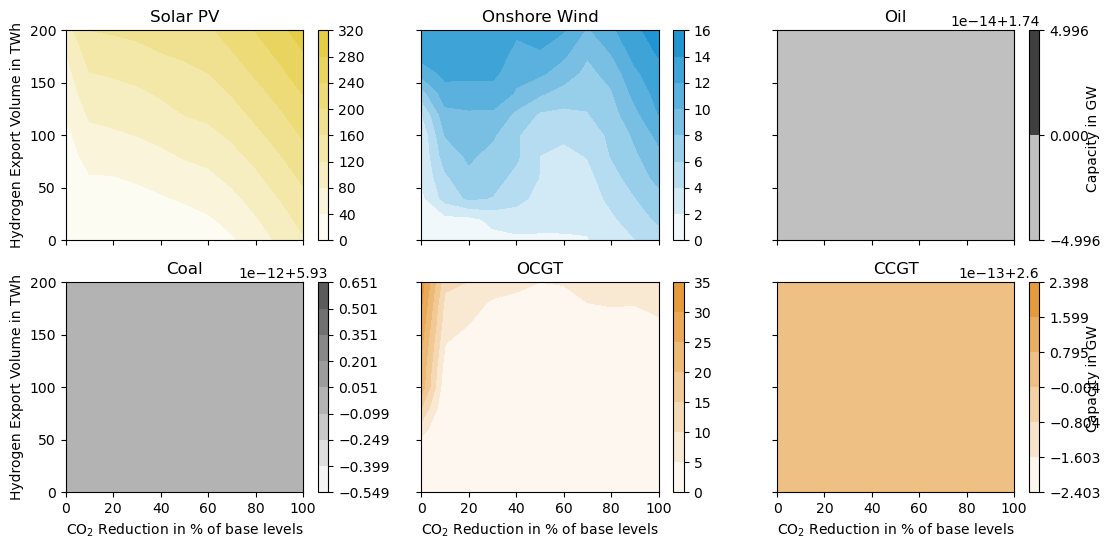

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6), sharex=True, sharey=True)

# Add x- and y-labels
axes[1,0].set_xlabel("CO$_2$ Reduction in % of base levels")
axes[1,1].set_xlabel("CO$_2$ Reduction in % of base levels")
axes[1,2].set_xlabel("CO$_2$ Reduction in % of base levels")
axes[1,0].set_ylabel("Hydrogen Export Volume in TWh")
axes[0,0].set_ylabel("Hydrogen Export Volume in TWh")

# Create subplots
tech = "Onshore Wind"
subplot(axes[0,1], tech)

tech = "Solar PV"
subplot(axes[0,0], tech)

tech = "oil"
subplot(axes[0,2], tech)

tech = "Coal"
subplot(axes[1,0], tech)

tech = "OCGT"
subplot(axes[1,1], tech)

tech = "CCGT"
plot = subplot(axes[1,2], tech)

print("Warning: Not including Run-of-river (ror)")

# Colorbar outside function
fig.text(0.91, 0.7, cbar_label[category], va='center', rotation='vertical')
fig.text(0.91, 0.3, cbar_label[category], va='center', rotation='vertical')

# Secondary y-axis
# ax2 = plt.gca().twinx()
# h2export_secondary = h2export / el_base_demand
# ax2.set_ylabel("H2-Exp/El-base-demand")
# ax2.set_ylim(0, max(h2export_secondary))  # Adjust the limit based on your data

plt.show()

# Save the figure
fig.savefig(f"{OUTPUT}/subcontour_{category}.pdf", dpi=300, bbox_inches="tight")